In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from matplotlib.pyplot import imshow
import pandas as pd

In [3]:
numcat = 6 #number of categories
categories = ['AbdomenCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'HeadCT']

In [53]:
# directory = r'./Medical_MNIST/'
# train, test = [], []
# for i in range(numcat):
#     imagearray = []
#     for image_raw in os.listdir(directory + categories[i]):
#         image_np = (np.array(Image.open(os.path.join(directory + categories[i], image_raw))).flatten())
#         image = np.append(image_np, i)
#         imagearray.append(image.astype('uint8'))
        
#     train += imagearray[0:int(0.8*len(imagearray))]
#     test += imagearray[int(0.8*len(imagearray)):]
# data = np.array(imagearray)
# train = np.array(train)
# test = np.array(test)

KeyboardInterrupt: 

In [4]:
# np.save('Medical_train.npy', train)
# np.save('Medical_test.npy', test)

In [9]:
train = np.load('Medical_train.npy')
test = np.load('Medical_test.npy')
#shuffle train and test sets


In [10]:
np.random.shuffle(train)
np.random.shuffle(test)
#splitting into x and y - for both train and test sets
x_train, y_train = train[:, :-1], train[:, -1]
x_test, y_test = test[:, :-1], test[:, -1]

cols = x_train.shape[1]

for i in range(cols):
    train_col = x_train[:,i]
    train_mean = train_col.mean()
    train_std = train_col.std()
    x_train[:,i] = (x_train[:,i] - train_mean)/train_std
    
    test_col = x_test[:,i]
    test_mean = test_col.mean()
    test_std = test_col.std()
    x_test[:,i] = (x_test[:,i] - test_mean)/test_std

In [11]:
train_ones = np.ones((x_train.shape[0],1), dtype=x_train.dtype)
X = np.append(x_train,train_ones,axis=1)
print(X.shape) 
test_ones = np.ones((x_test.shape[0],1), dtype=x_test.dtype)
X_test = np.append(x_test,test_ones,axis=1)
print(X_test.shape)
Y = np.reshape(y_train,(y_train.shape[0],1))
print(Y.shape)
Y_test = np.reshape(y_test,(y_test.shape[0],1))
print(Y_test.shape)

(47163, 4097)
(11791, 4097)
(47163, 1)
(11791, 1)


In [12]:
classes = 6

Y_oh = np.zeros((Y.shape[0],classes))

for i in range(Y.shape[0]):
    Y_oh[i,Y[i]] = 1
    
Y_test_oh = np.zeros((Y_test.shape[0],classes))

for i in range(Y_test.shape[0]):
    Y_test_oh[i,Y_test[i]] = 1

print(Y_oh)
print(Y)

[[0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 ...
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]
[[2]
 [2]
 [5]
 ...
 [0]
 [3]
 [1]]


In [13]:
#subtract the maximum of each array to stabilise exponential calculation using the identity softmax(x - c) = softmax(x)

def softmax(Z):
    prob = np.zeros(Z.shape)
    
    for i in range(Z.shape[0]):
        Z_stable = Z[i] - max(Z[i])
        exp = np.exp(Z_stable)
        total = np.sum(exp)
        prob[i] = exp/total
    return prob

In [14]:
# W = np.random.rand(4097,6)

#add a small positive value to make sure log does not overflow

def loss(W,X,Y):
    Z = np.matmul(X,W)
    # dim Z = (47163, 6)
    p = softmax(Z)
    
    #loss = -y(i)logp(i) or y product with p
    loss = 0
    
    epsilon = 1e-5
    
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if(Y[i,j] != 0):
                loss = loss - np.log(p[i,j] + epsilon)
    
    return loss/Y.shape[0]

In [15]:
def gradient(W,X,Y):
    Z = np.matmul(X,W)
    p = softmax(Z)
    
    #dim p/Y = (47163,6)
    #dim X = (47163,4097)
    grad = np.matmul(X.T,(p-Y))
    
    return grad

In [16]:
def sgd(W,X,Y,X_test,Y_test,rate,num_iter):
    train_loss, test_loss = [], []
    for _ in range(0, num_iter):
        grad = gradient(W,X,Y)
        W = W - rate*grad
        train_loss.append(loss(W,X,Y))
        test_loss.append(loss(W,X_test,Y_test))
    return W, train_loss, test_loss

In [19]:
num_iter = 20
rate = 0.01

In [ ]:
W = np.random.rand(4097,6)**0.01

print(W)

W, train_loss, test_loss = sgd(W,X,Y_oh,X_test,Y_test_oh,rate,num_iter)

print(W)

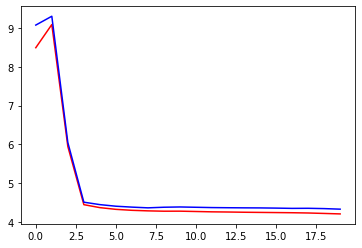

In [12]:
plt.plot(train_loss, 'r')
plt.plot(test_loss, 'b')
plt.show()

In [22]:
def lossE(W,X,Y,lam1, lam2):
    square_loss = np.mean((np.matmul(X,W) - Y)**2) # + lam1*np.sum(np.multiply(W,W)) + lam2*np.sum(np.abs(W))
    return square_loss

def gradientE(W,X,Y,lam1, lam2):
   # W_grad = np.zeros(W.shape)

    Z = np.matmul(X,W)
    p = softmax(Z)
    
    grad = -2*(X.T.dot(())) # - 2*lam2*W - lam1*W
    return grad

def sgdE(W,X,Y,X_test,Y_test,rate,num_iter,lam1,lam2):
    train_loss, test_loss = [], []
    for _ in range(0, num_iter):
        grad = gradientE(W,X,Y,lam1,lam2)
        W = W + rate*grad
        train_loss.append(lossE(W,X,Y,lam1,lam2))
        test_loss.append(lossE(W,X_test,Y_test,lam1,lam2))
    return W, train_loss, test_loss

[[7.00223027e+116 7.00192084e+116 7.00234464e+116 7.00340681e+116
  7.00344917e+116 7.00386810e+116]
 [6.90895343e+116 6.90864813e+116 6.90906628e+116 6.91011431e+116
  6.91015610e+116 6.91056944e+116]
 [3.18495406e+113 3.18481332e+113 3.18500608e+113 3.18548921e+113
  3.18550847e+113 3.18569902e+113]
 ...
 [6.90424976e+116 6.90394466e+116 6.90436253e+116 6.90540985e+116
  6.90545161e+116 6.90586467e+116]
 [6.83002643e+116 6.82972461e+116 6.83013799e+116 6.83117404e+116
  6.83121535e+116 6.83162398e+116]
 [4.48868227e+114 4.48848391e+114 4.48875559e+114 4.48943648e+114
  4.48946363e+114 4.48973218e+114]]


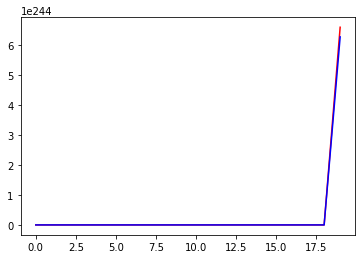

In [23]:
W_sq = np.random.rand(4097,6)**0.01

lam1 = 1
lam2 = 0.1

W_sq, train_loss, test_loss = sgdE(W,X,Y_oh,X_test,Y_test_oh,rate,num_iter,lam1,lam2)

print(W_sq)

plt.plot(train_loss, 'r')
plt.plot(test_loss, 'b')
plt.show()